# Document 3.Prototype contributon to solving issue

> This report documents the results of two NLP tasks performed on the STEM Twitter data:
> * 1. Evaluate the performance of gender classification using a Random Forest classifier on the Tweet dataset.
> * 2. A sentiment analysis of each Tweet, to determine the sentiment towards women and men in STEM Tweets.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import re
import string
import pickle
import seaborn as sns
from textblob import TextBlob

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve


import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
%matplotlib inline 

## NLP Task 1

## Literature review: Random Forest classifier
> The Random Forest classifier is a versatile and effective supervised classification algorithm (Donges, 2019). It comprises a number of decision trees, specified by the user, which operate together yet independently; for items in a dataset, each decision tree in the ‘forest’ will make a prediction based on a random sample of the data, and the class with the most predictions is used as the model’s output (Liaw & Weiner, 2002; Yiu, 2019). The trees are trained via Bootstrap Aggregation, also known as ‘bagging’, which allows each tree to make predictions using different features of the same dataset (Donges, 2019; Yiu, 2019). Bagging employs a combination of learning models, improving the overall result (Donges, 2019). Individual trees protect each other against error (Yiu, 2019) to make more accurate and stable predictions (Donges, 2019; Liaw & Weiner, 2002).


## Rationale
> This task will consist of a Random Forest Classifier trained first on the original Tweet dataset, and secondly on an augmented version of this dataset. The Random Forest model was chosen because of its resistance to overfitting (Donges, 2019). Models trained on text data are prone to overfitting, because if a test set contains words outside of the vocabulary in the training set, the model can struggle to make predictions (Kreiger, 2020). Random Forest models also increase accuracy of predictions by cross-validation, and they are powerful enough to use on large datasets (Anurag, 2018).

> A supervised classification task is an ideal tool for exposing bias in machine learning algorithms; among the available outputs is a confusion matrix, which reveals exactly how data are misclassified (Kreiger, 2020). From there, decisions can be made to mitigate any bias identified. Because the Tweet dataset contains a disproportionate number of Tweets about men, the bias towards the male class should be reflected, and may even be amplified in the classification results (Sun et al., 2019). 

> It should be noted that simply reducing the number of male-coded Tweets to be equivalent to that of female-coded Tweets ignores the social framework within which the data have been collected.


In [2]:
# Read the dataset
df = pd.read_csv("tweets_df.csv")
df["Tweet"] = df["Text"]
df = df[["Tweet", "Gender"]]
df = df.replace(to_replace = "F", value = 1)
df = df.replace(to_replace = "M", value = 0)
df.head(10)


## Data Pre-Processing
> The cleaned Tweets dataset required further processing before applying NLP tasks.

> * 1.	Conversion of ‘M’ and ‘F’ classes to ‘0’ and ‘1’.
> * 2.	Specification of X as Tweet ‘Text’ and y as gender/‘Target’.
> * 3.	Lemmatization, to group different forms of similar words, to be analysed as a single term.
> * 4.	Vectorisation, to remove English stop words and convert words to numbers, allowing computation of language data.
> * 5.	Tfidf transformation, to assign a weighting to each word, weigh the frequency of each term (TF) within a corpus and multiply it by the inverse document frequency (IDF), reducing the weighting of common words (Goel, 2018).

> The dataset was then split into a train set and a test set, containing 80% and 20% of the data, respectively. Because the dataset is so imbalanced, the paramater stratify = y was used to ensure that, in both the train and test sets, the proportion of male and female Tweets remained the same as in the original dataset (Kreiger, 2020). 



In [3]:
X = df.iloc[:,0:].values
y = df.iloc[:,1:].values

In [4]:
documents = []

from nltk.stem import WordNetLemmatizer

stemmer = WordNetLemmatizer()

for sen in range(0, len(X)):
    # Remove all the special characters
    document = re.sub(r'\W', ' ', str(X[sen])) 
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)  
    # Remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document)   
    # Substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)   
    # Removing prefixed 'b'
    document = re.sub(r'^b\s+', '', document)   
    # Converting to Lowercase
    document = document.lower()  
    
    # Lemmatization
    document = document.split()
    document = [stemmer.lemmatize(word) for word in document]
    document = ' '.join(document)
    
    documents.append(document)

In [5]:
# Create vocabularies
from sklearn.feature_extraction.text import TfidfVectorizer
tfidfconverter = TfidfVectorizer(max_features=1500, min_df=5, max_df=0.7, stop_words=stopwords.words('english'))
X = tfidfconverter.fit_transform(documents).toarray()

In [6]:
# Split train and test (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)

### Random forest hyperparameters
> Although the Random Forest algorithm does not always require hyperparameters due to its general effectiveness (Meinert, 2020), four hyperparameters were incorporated, to give the model the best chance of making satisfactory predictions:
> * n_estimators:  The number of trees the algorithm builds before finalising predictions. A high number generally yields better performance, but can slow computation (Donges, 2019; Meinert, 2020). Using the optimal number reduces the possibility of overfitting the model (Liaw & Weiner, 2002). 
> * max_depth: The maximum depth of each tree. The default value,  ’None’, allows each tree to expand until all data on the leaf comes from the same class (scikit-learn.org) Specifying a max_depth value may reduce computation time (Meinert, 2020).
> * min_sample_leaf and min_sample_split: The minimum number of leaves required to be at a leaf node and to split an internal node, respectively (Meinert, 2020).

> Figure 4 shows the validation curves for each of these hyperparameters: 


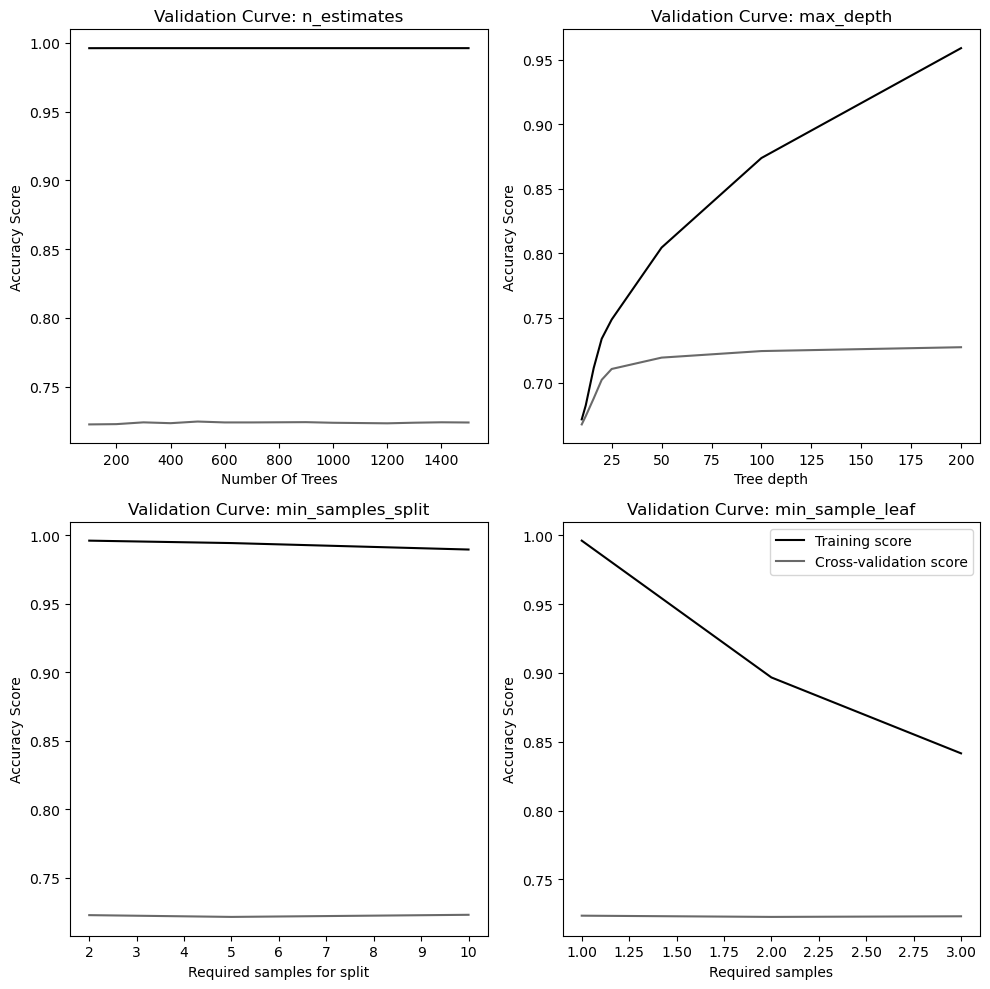

In [8]:
from sklearn.model_selection import validation_curve
from matplotlib.pyplot import figure

num_est= [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000,1100, 1200, 1300, 1400, 1500]
max_depth=[10, 12, 16, 20, 25, 50, 100, 200]
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 3]

figure(figsize=(10, 10), dpi=100)

plt.subplot(2, 2, 1)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'n_estimators', 
                                param_range = num_est, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(num_est, train_mean, label="Training score", color="black")
plt.plot(num_est, test_mean, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve: n_estimates")
plt.xlabel("Number Of Trees")
plt.ylabel("Accuracy Score")



plt.subplot(2, 2, 2)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'max_depth', 
                                param_range = max_depth, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(max_depth, train_mean, label="Training score", color="black")
plt.plot(max_depth, test_mean, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve: max_depth")
plt.xlabel("Tree depth")
plt.ylabel("Accuracy Score")

plt.subplot(2, 2, 3)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'min_samples_split', 
                                param_range = min_samples_split, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(min_samples_split, train_mean, label="Training score", color="black")
plt.plot(min_samples_split, test_mean, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve: min_samples_split")
plt.xlabel("Required samples for split")
plt.ylabel("Accuracy Score")


plt.subplot(2, 2, 4)
train_scoreNum, test_scoreNum = validation_curve(
                                RandomForestClassifier(),
                                X = X_train, y = y_train.ravel(), 
                                param_name = 'min_samples_leaf', 
                                param_range = min_samples_leaf, cv = 3)
train_mean = np.mean(train_scoreNum, axis=1)
train_std = np.std(train_scoreNum, axis=1)

test_mean = np.mean(test_scoreNum, axis=1)
test_std = np.std(test_scoreNum, axis=1)
plt.plot(min_samples_leaf, train_mean, label="Training score", color="black")
plt.plot(min_samples_leaf, test_mean, label="Cross-validation score", color="dimgrey")

plt.title("Validation Curve: min_sample_leaf")
plt.xlabel("Required samples")
plt.ylabel("Accuracy Score")

plt.tight_layout()
plt.legend(loc="best")

plt.show()


In [11]:
# Apply the classifier using the hyperparameters defined above
classifier = RandomForestClassifier(n_estimators=900, max_depth = 200, min_samples_split = 2, min_samples_leaf = 1, random_state=0)
model = classifier.fit(X_train, y_train.ravel()) 

y_pred = model.predict(X_test)

## Preliminary assessment of Task Performance
> Figure 5 shows that the algorithm has over-predicted the male class. This result was expected, as the male class comprises a much higher proportion of Tweets than the female class.


In [12]:
print("Confusion matrix:")
print(confusion_matrix(y_test,y_pred))
print(" ")
print(" ")
print("Classification report:") 
print(classification_report(y_test,y_pred))
print(" ")
print("Accuracy score:", accuracy_score(y_test, y_pred))

Confusion matrix:
[[3048  269]
 [1093  623]]
 
 
Classification report:
              precision    recall  f1-score   support

           0       0.74      0.92      0.82      3317
           1       0.70      0.36      0.48      1716

    accuracy                           0.73      5033
   macro avg       0.72      0.64      0.65      5033
weighted avg       0.72      0.73      0.70      5033

 
Accuracy score: 0.7293860520564276


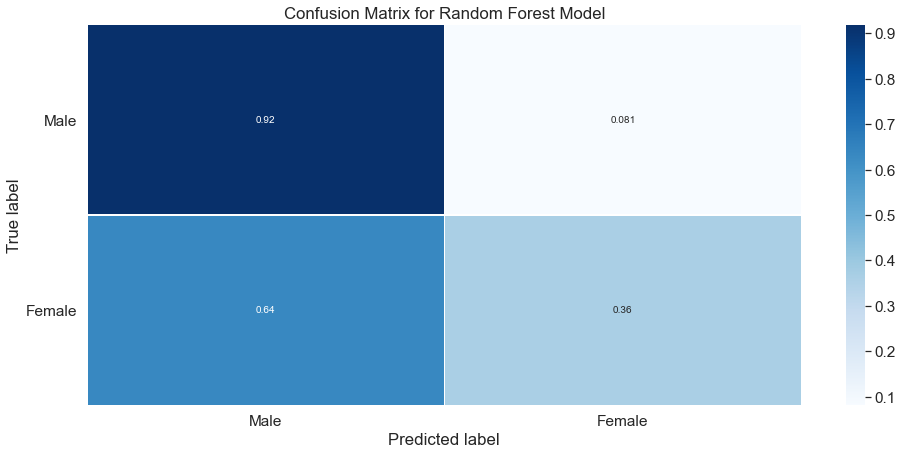

In [13]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, y_pred)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Blues, linewidths=0.2)

# Add labels to the plot
class_names = ['Male', 'Female']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2, class_names, rotation=0)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# 

> <i>Figure 6</i> shows the results of the 'Elbow Method' of determining a value k, corresponding to the possible number of clusters in the dataset. There is an 'elbow' at k=7, suggesting that this is the optimal number of clusters. This is contrary to expectations that there may be two clusters, corresponding to gender. The word clouds below show that at k = 2, there is considerable overlap in the most common words in both clusters. At k=7, there is a much stronger distinction, corresponding to STEM field (i.e. mathematics, engineering, etc). This suggests that the bias in STEM Tweets is not due to bias in the language used to describe men and women in STEM, but rather due to the representation bias towards men. 

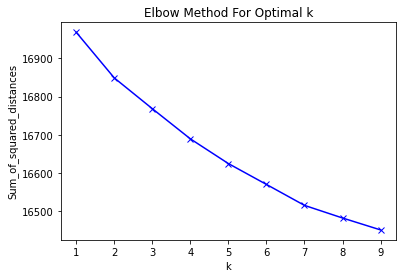

In [7]:
# Perform Kmeans cluster analysis
from sklearn.cluster import KMeans
Sum_of_squared_distances = []
K = range(1,10)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    Sum_of_squared_distances.append(km.inertia_)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

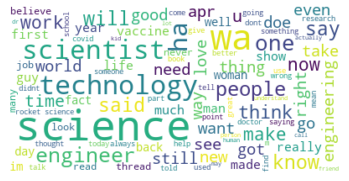

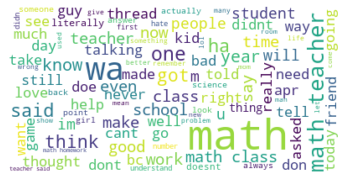

In [8]:
true_k = 2
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
tweet_cl=pd.DataFrame(list(zip(document,labels)),columns=['Tweet','cluster'])

from wordcloud import WordCloud
result={'cluster':labels,'wiki':documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    titles=tweet_cl[tweet_cl.cluster==k]['Tweet']  
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

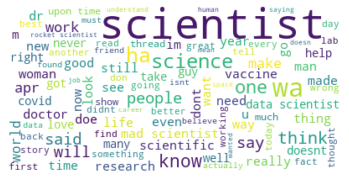

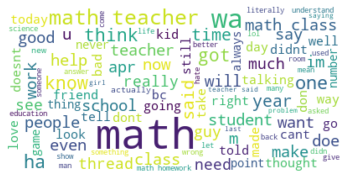

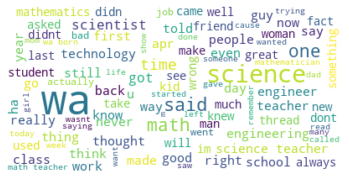

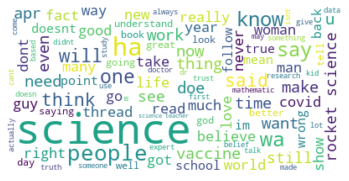

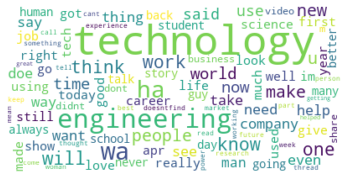

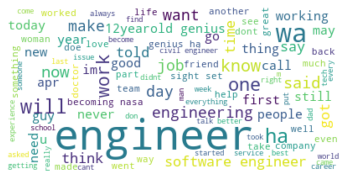

In [9]:
true_k = 6
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=200, n_init=10)
model.fit(X)
labels=model.labels_
tweet_cl=pd.DataFrame(list(zip(document,labels)),columns=['Tweet','cluster'])
from wordcloud import WordCloud
result={'cluster':labels,'wiki':documents}
result=pd.DataFrame(result)
for k in range(0,true_k):
    s=result[result.cluster==k]
    text=s['wiki'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    titles=tweet_cl[tweet_cl.cluster==k]['Tweet']  
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

## NLP Task 2

## Literature review: Sentiment analysis using VADER
> Sentiment analysis is a NLP process that aims to classify language data with respect to the underlying attitudes, emotions or sentiment (Gautam & Yadav, 2014; Neethu, 2013; Pozzi et al., 2017). A statement can be classified along a continuum from positive to negative sentiment (Gautam & Yadav, 2014). These data can then be used to evaluate opinions towards any number of topics (Pozzi et al., 2017). Sentiment analysis can be applied to individuals, but it is particularly useful for evaluating public sentiment on a given topic. Social media provides an ideal source of sentiment data (Pozzi et al., 2017), and the results can inform decision-making in any number of situations.

> The VADER sentiment analysis tool, in the NLTK package, provides a positive or negative polarity to language data (Beri, 2020). It can be applied directly to unlabelled text and can also evaluate intensity of emotion. The sentiment score is the sum of the intensity of each word in a text (Beri, 2020).

## Rationale
> The rationale for undertaking a sentiment analysis is as follows: If there is no discernible difference between the language used to discuss women and men in STEM, then it stands to reason that the general sentiment towards women and men in STEM would be similar. If this is the case, then this would confirm the source of the bias as being due to underrepresentation of women in STEM, rather than some inherent language bias.

## Data Pre-Processing
> There was limited pre-processing involved prior to sentiment analysis, because VADER can be used on raw text.

## Hyperparameters
> Likewise, there are no hyperparameters used in VADER.


In [19]:
df = pd.read_csv('tweets_df.csv')

sid = SentimentIntensityAnalyzer()
semtiment_polarity = df.apply(lambda r: sid.polarity_scores(r.Text), axis=1)

# turn the result into a data frame and add as columns to the original data
sentiment_df = pd.DataFrame(list(semtiment_polarity))
Tweet_sentiment = df.join(sentiment_df)

# assign 'pos, neg, neutral' based on compund value
def sentiment (row):
    if row['compound'] >= 0.05 :
        return 'positive'
    elif row['compound'] <= -0.05 :
        return 'negative'
    else :
        return 'neutral'
    
Tweet_sentiment['sentiment'] = Tweet_sentiment.apply (lambda row: sentiment(row), axis=1)

Tweet_sentiment.head()



,Handle,Text,Likes,Gender,Topic,neg,neu,pos,compound,sentiment
0,@Rick_Crainium,and 17 othersSorry to interrupt he Good Morn...,3.6K,M,science,0.114,0.737,0.149,0.3182,positive
1,@keithebae,Seongmin didnt attend a tutoring academy but h...,1,M,mathematics,0.000,1.000,0.000,0.0000,neutral
2,@JaredLesterSmi1,and 2 othersMaybe it a lack of science educa...,0,M,science,0.219,0.662,0.119,-0.7396,negative
3,@Elonnieee,I’m so glad my bf is smartso he can do my math...,2,M,mathematics,0.000,0.798,0.202,0.5095,positive
4,@MainNashville,Meet Gena Johnson who has worked with John Pri...,0,F,engineering,0.000,0.950,0.050,0.5423,positive


## Preliminary assessment of Task Performance
> As expected, the general  sentiment towards men and women does not vary significantly (Figure 7). The sentiment towards women and men in STEM follow similar trends. Figure 8 shows that Tweets about women are identified as being slightly more positive. These findings are important, because they confirm that gender bias may not always relate to language, as might have been expected.

Figure 8: STEM tweets about women and men have similar polarities


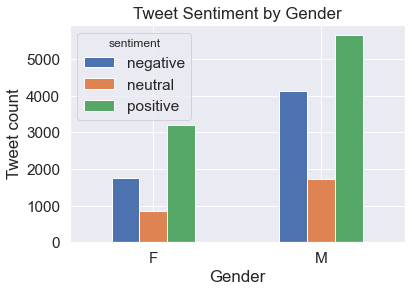

In [22]:
sentiment = Tweet_sentiment.groupby(['Gender', 'sentiment']).sentiment.count().unstack()
sentiment.plot(kind='bar')
plt.title('Tweet Sentiment by Gender')
plt.xlabel('Gender')
plt.ylabel('Tweet count')
plt.xticks(rotation = 0)

print("""Figure 8: STEM tweets about women and men have similar polarities""")


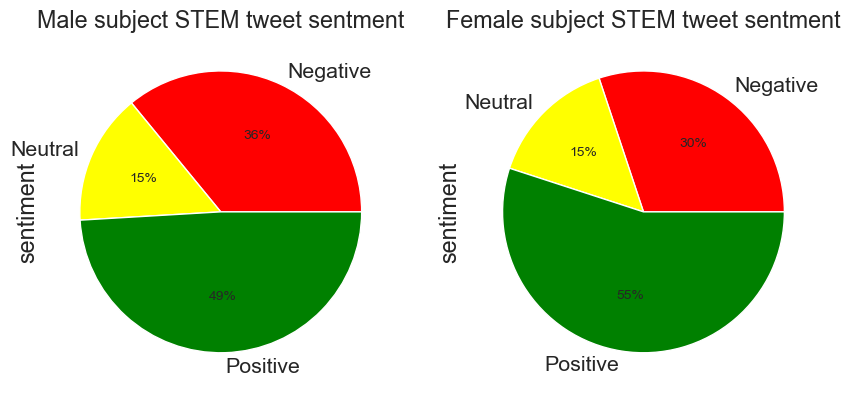

Figure 9: Tweets about women in STEM are slightly more positive than Tweets about men.


In [24]:
df_M = Tweet_sentiment.loc[df['Gender']== "M"]
df_F = Tweet_sentiment.loc[df['Gender']=="F"]

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

labels = ['Negative', 'Neutral', 'Positive']

figure(figsize=(10, 10), dpi=100)

                        
plt.subplot(1, 2, 1)
df_M.groupby(['Gender', 'sentiment']).sentiment.count().plot(kind='pie', autopct='%1.0f%%', labels=labels, colors=["red", "yellow", "green"])
matplotlib.pyplot.title(label="Male subject STEM tweet sentment", fontdict=None, loc='center', pad=None)

plt.subplot(1, 2, 2)
df_F.groupby(['Gender', 'sentiment']).sentiment.count().plot(kind='pie', autopct='%1.0f%%', labels=labels, colors=["red", "yellow", "green"])
matplotlib.pyplot.title(label="Female subject STEM tweet sentment", fontdict=None, loc='center', pad=None)

plt.show()

print("Figure 9: Tweets about women in STEM are slightly more positive than Tweets about men.")

## Final remarks: Identifying the source of bias in NLP.
> This analysis showed that, within STEM-related topics, the language used to discuss men and women in STEM is not significantly different (this result may not be universal; a dataset containing Tweets about engineering and childcare may yield different results). The sentiment analysis supports these findings.

> While sentiment towards women in STEM is positive, they are still significantly underrepresented in the data and in real life (Robnett, 2016). The bias towards classifying STEM topics as relating to men has implications for NLP tasks,  because this bias is learned and amplified by machine learning algorithms (Sun et al., 2019). perpetuating potentially damaging (not to mention old fashioned) stereotypes regarding women in STEM (i.e. man is to computer programmer as woman is to homemaker) (Wei, 2020). 

> Wei (2020) suggests that the most effective way to deal with socially-curated bias is to include more data about those who are underrepresented. The solution to this problem is therefore greater than natural language processing and machine learning alone – it simply requires more women to be involved in STEM. Paradoxically, machine learning algorithms may hamper this ideal by amplifying the already acute gender imbalance. It is hoped that this research on identifying the source of bias might contribute to addressing the broader issue within NLP.


## References


> Agarwal, B., & Mittal, N. (2016). Prominent feature extraction for sentiment analysis. Springer.

>  Albon, C. (2017, December 20). Plot the validation curve. Chris Albon. https://chrisalbon.com/machine_learning/model_evaluation/plot_the_validation_curve/

>  Anurag, A. (2018, August 17). Random Forest Analysis in ML and when to use it. New Gen Apps. https://www.newgenapps.com/blog/random-forest-analysis-in-ml-and-when-to-use-it/#:~:text=Random%20forest%20algorithm%20can%20be,a%20large%20proportion%20of%20data.

> Australian Government. (2020). Advancing Women in STEM strategy. Industry.gov.au. https://www.industry.gov.au/data-and-publications/advancing-women-in-stem-strategy/snapshot-of-disparity-in-stem/women-in-stem-at-a-glance

> Beri, A. (2020, May 28). Sentimental analysis using VADER: Interpretation and classification of emotions. Towards Data Science. https://towardsdatascience.com/sentimental-analysis-using-vader-a3415fef7664

> Chowdhury, G. (2003). Natural language processing. Annual review of information science and technology, 37(1), 51-89.

> Donges, N. (2019, June 16). A complete guide to the random forest algorithm. Built In. https://builtin.com/data-science/random-forest-algorithm

> Ethayarajh, K. (2020, November 11). Measuring Bias in NLP with Confidence. Stanford AI. http://ai.stanford.edu/blog/bias-nlp/#:~:text=Countless%20studies%20have%20found%20that,when%20given%20the%20right%20prompt.

> Gautam, G., & Yadav, D. (2014). Sentiment analysis of twitter data using machine learning approaches and semantic analysis. In Seventh International Conference on Contemporary Computing (IC3) (pp. 437-442). IEEE.

> Goel, V. (2018, November 2) Applying machine learning to classify an unsupervised text document. Towards Data Science. https://towardsdatascience.com/applying-machine-learning-to-classify-an-unsupervised-text-document-e7bb6265f52 


> Hirschberg, J., & Manning, C. (2015). Advances in natural language processing. Science, 349(6245), 261-266.

> Kreiger, J. (2020, January 13). Evaluating a Random Forest model. Medium.com. https://medium.com/analytics-vidhya/evaluating-a-random-forest-model-9d165595ad56

> Liaw, A., & Wiener, M. (2002). Classification and regression by Random Forest. R News, 2(3), 18-22. 

> Malik, U. (2018, January 8). Text Classification with Python and Scikit-Learn. Stack Abuse. https://stackabuse.com/text-classification-with-python-and-scikit-learn/

> Meinert, R. (2019, June 6). Optimizing Hyperparameters in Random Forest Classification: What hyperparameters are, how to choose hyperparameter values, and whether or not they’re worth your time. Towards Data Science. https://towardsdatascience.com/optimizing-hyperparameters-in-random-forest-classification-ec7741f9d3f6

> Neethu, M. S., & Rajasree, R. (2013). Sentiment analysis in twitter using machine learning techniques. In Fourth International Conference on Computing, Communications and Networking Technologies (pp. 1-5). ICCCNT.

> Pozzi, F. A., Fersini, E., Messina, E., & Liu, B. (2016). Sentiment analysis in social networks. Morgan Kaufmann.
Robnett, R. D. (2016). Gender bias in STEM fields: Variation in prevalence and links to STEM self-concept. Psychology of  Women Quarterly, 40(1), 65-79.

> Silman, J. (2019, March 23). Scrape tweets using Selenium. Medium. https://medium.com/@jamessilman/scrape-tweets-using-selenium-3f713873439

> Sun, T., Gaut, A., Tang, S., Huang, Y., El Sherief, M., Zhao, J., & Wang, W. Y. (2019). Mitigating gender bias in natural language processing: Literature review. arXiv preprint arXiv:1906.08976.

> Wei, J. (2020, September 2). Bias in Natural Language Processing (NLP): A Dangerous But Fixable Problem. Towards Data Science. https://towardsdatascience.com/bias-in-natural-language-processing-nlp-a-dangerous-but-fixable-problem-7d01a12cf0f7

> Yiu, T. (2019, June 12). Understanding Random Forest: How the Algorithm Works and Why it Is So Effective. Towards Data Science. https://towardsdatascience.com/understanding-random-forest-58381e0602d2
